# 多项式回归

In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
from d2l import torch as d2l

### 一、生成数据集

y = 5 + 1.2x - (3.4/2!)x^2 + (5.6/3!)x^3 + noi

noi为噪声项，服从均值为0，标准差为0.1的正态分布。

In [2]:
max_degree = 20 #多项式的最大阶数
n_train , n_test = 100, 100 #训练数据和测试数据的大小
true_w = np.zeros(max_degree)  #分配大量空间
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size = (n_train + n_test , 1))
np.random.shuffle(features)
poly_features = np.power(features , np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1)   # gamma(n) = (n-1)!
# labels的维度:(n_train+n_test)
labels = np.dot(poly_features , true_w)
labels += np.random.normal(scale=0.1 , size=labels.shape)

In [3]:
true_w , features , poly_features , labels = [torch.tensor(x,dtype=torch.float32)
                                               for x in [true_w, features , poly_features , labels]]


In [4]:
features[:2] , poly_features[:2,:], labels[:2]

(tensor([[-1.7954],
         [-0.3620]]),
 tensor([[ 1.0000e+00, -1.7954e+00,  1.6117e+00, -9.6452e-01,  4.3292e-01,
          -1.5545e-01,  4.6515e-02, -1.1930e-02,  2.6774e-03, -5.3410e-04,
           9.5891e-05, -1.5651e-05,  2.3416e-06, -3.2339e-07,  4.1471e-08,
          -4.9638e-09,  5.5699e-10, -5.8823e-11,  5.8672e-12, -5.5441e-13],
         [ 1.0000e+00, -3.6199e-01,  6.5519e-02, -7.9057e-03,  7.1545e-04,
          -5.1797e-05,  3.1250e-06, -1.6160e-07,  7.3124e-09, -2.9411e-10,
           1.0647e-11, -3.5036e-13,  1.0569e-14, -2.9430e-16,  7.6095e-18,
          -1.8364e-19,  4.1547e-21, -8.8468e-23,  1.7792e-24, -3.3897e-26]]),
 tensor([-7.8642,  4.2324]))

### 二、对模型进行训练和测试

In [5]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  #损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = d2l.reshape(y, out.shape)
        l = loss(out, y)
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [6]:
def train(train_features , test_features, train_labels , test_labels, num_epochs = 400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    #不设偏置，因为已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape , 1 ,bias= False))
    batch_size = min(10 , train_labels.shape[0])
    train_iter = d2l.load_array((train_features , train_labels.reshape(-1,1)), batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size , is_train=False)
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',yscale='log',
                            xlim = [1 , num_epochs], ylim=[1e-3 , 1e2],
                            legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net , train_iter , loss , trainer)
        if epoch ==0 or (epoch+1) % 20 == 0:
            animator.add(epoch+1 ,(evaluate_loss(net , train_iter , loss),
                                    evaluate_loss(net , test_iter , loss)))
    print('weight:' , net[0].weight.data.numpy())

### 三、三阶多项式函数拟合（正常）

weight: [[ 5.0058346  1.2191359 -3.400214   5.547866 ]]


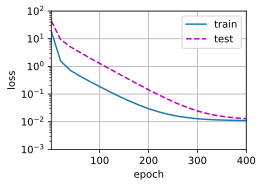

In [7]:
train(poly_features[:n_train, :4] , poly_features[n_train:, :4],
      labels[:n_train],labels[n_train:])

### 四、线性函数拟合（欠拟合）

weight: [[3.3319144 3.4754584]]


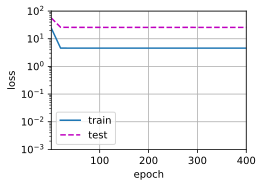

In [8]:
#选取2个维度，即线性函数
train(poly_features[:n_train, :2] , poly_features[n_train:, :2],
      labels[:n_train],labels[n_train:])

### 五、高阶多项式函数拟合（过拟合）

weight: [[ 5.0008907   1.2614126  -3.339823    5.1960745  -0.33953795  1.4478828
   0.25291228  0.07072898  0.13401271 -0.19167367 -0.09236366 -0.21640767
   0.11902812  0.03107277  0.09531427  0.14886172 -0.16831341  0.07483867
   0.06385478  0.08716118]]


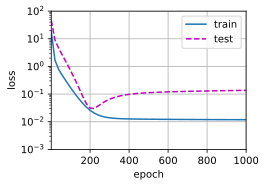

In [9]:
#选取所有维度
train(poly_features[:n_train, :] , poly_features[n_train:, :],
      labels[:n_train],labels[n_train:],num_epochs=1000)